# Artificial Quantum Life:

Esta presentación surge a partir del essay: Quantum Artificial Life in an IBM Quantum Computer.

En este cuaderno mostramos la forma en la que hemos implementado la creación de vida artificial y sus procesos de reproducción. Dentro de estos se encuentran los siguientes:
- Asexual
- Sexual

Asimismo, proporcionamos un conjunto de métodos para la creación de estos circuitos y el análisis de los mismos.

In [1]:
from qiskit import *
from qiskit.aqua.circuits.gates import cry

from qiskit.visualization import plot_histogram

import numpy as np
import random

import sys
import matplotlib.pyplot as plt

Parametros de referencia y funciones de visualización.

In [2]:
theta = 2*np.pi/3
thetaR = np.pi/4

fileNum = 30

# Chose your prefered backend
sim = Aer.get_backend('qasm_simulator') 

# Devuelve el valor esperado de un circuito con un solo bit de registro
def getExpectedValue(qc, shots=8192):
    job = execute(qc, sim, shots=shots)

    count = job.result().get_counts()
    a,b = [count[a]/shots if a in count else 0 for a in ['0','1']]
    return a-b

def printHistogram(qc, shots=8192):
    job = execute(qc, sim, shots=shots)
    return plot_histogram(job.result().get_counts())


A la hora de simular el paso del tiempo y sus consecuencias sobre el individuo, hemos optado por agregar una ancilla la cual degenerara el fenotipo. 

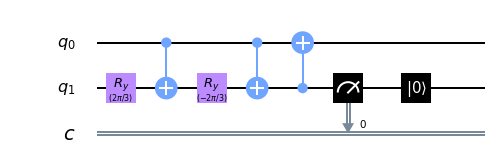

In [3]:
# Devuelve la Gate time_Lapse que aplica una iteracion de paso de tiempo
# 
# Changed : Float que representa el valor en radianes del gate CRY
def getDecoherence(changed):
    decoherenceG = QuantumCircuit(2,1, name='decoherence')
    decoherenceG.ry(changed,1)
    decoherenceG.cx(0,1)
    decoherenceG.ry(-changed,1)
    decoherenceG.cx(0,1)
    decoherenceG.cx(1,0)
    decoherenceG.measure([1],[0])
    decoherenceG.reset(1)
    return decoherenceG


## Creación y clonación de individuos

Un circuito simulador es un conjunto de pasos de tiempo con unas pautas de clonación de elementos. El proceso de creación de un individuo comenzaría estableciendo un estado a el qubit del genotipo del individuo inicial. Esto se puede hacer aplicando una puerta U3 con un ángulo en $x$. A continuación, clonamos el genotipo sobre el fenotipo aplicando un CNOT:

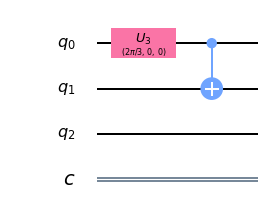

Una vez creado el individuo inicial, comenzaríamos la simulación dejando pasar una cantidad de tiempo que deseemos. En este caso aplicaremos solo una unidad de tiempo. Entonces, decidiremos clonar el individuo inicial. Para este proceso tendremos que copiar primero el genotipo del individuo inicial sobre otro qubit del segundo inidividuo y depués, copiaremos el valor del genotipo del segundo individuo sobre su fenpotipo:

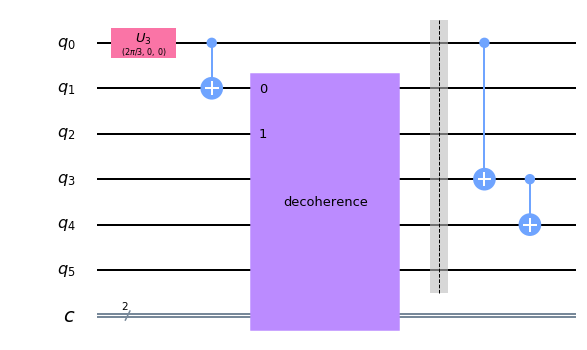

Este proceso puede extenderse de forma arbitraria, creando poblaciones tan grandes como queramos. Asimismo, podemos optar por limitar el número de habitantes pero establecer una cantidad de tiempo tan larga como deseemos.


## Poblaciones no relacionadas

Algunas veces, no buscaremos clonar la población, sino tener una población inicial de $n$ habitantes, aplicar varias iteraciones de tiempo sobre la poblacion y comprobar el estado de la misma. Dentro de estas poblaciones muchas veces lo que querremos es cambiar la forma en la que interactúa con el entorno. Por ahora hemos creado una función que crea los circuitos de estas para su modificación posterior.


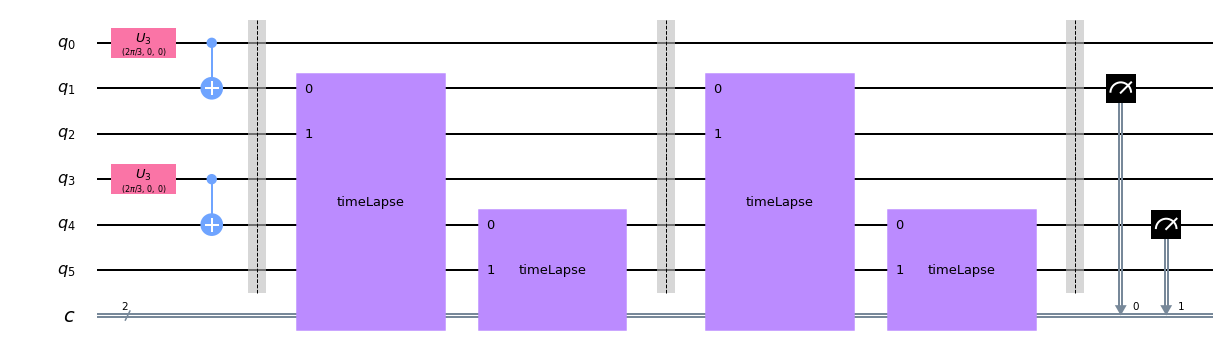



In [4]:
# Crea un circuito general de una Artificial Life de poblacion 1
#
# time    : Integer representando la cantidad de iteraciones
# initial : Float que representa los radiones de la gate U3 inicial
# changed : Float que representa los radianes de la gate CRY
# pop     : Integer representando la cantidad de poblacion que tendra el algoritmo
def getCircuit(pop=1,time=3, initial=theta, changed=theta, measure = True):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qc = QuantumCircuit(3*pop,pop)
    for i in range(pop):
        qc.u3(initial,0,0,i*3)
        qc.cx(i*3,i*3+1)
    qc.barrier()
    for i in range(0,time):
        #cry
        for j in range(pop):
            qc.append(decoherenceG, [j*3+1,j*3+2],[j])
        qc.barrier()
    if(measure):
        qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    return qc


# Aumenta el la cantidad de capas de tiempo del circuito.
def addTimeLapse(qc,time,measure=False, changed = theta):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qBits = int(len(qc.qubits)/3)
    for i in range(0,time):
        #cry
        for j in range(qBits):
            qc.append(decoherenceG, [j*3+1,j*3+2],[j])
        qc.barrier()
    if(measure):
        qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    


# Crea un escenario general de clonacion de poblacion asexual mediante clonacion exponencial
#
# time    : Integer representando la cantidad de iteraciones 
# pop     : Integer representando la cantidad de poblacion que tendra el algoritmo
# initial : Float que representa los radiones de la gate U3 inicial
# changed : Float que representa los radianes de la gate CRY
# mutationRate : Float que representa el ratio de mutacion
def getCircuitG(time=3, pop=2, initial=theta, changed=theta, mutationRate = 0, mutation=False):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qc = QuantumCircuit(3*pop,pop)
    qc.u3(initial,0,0,0)
    qc.cx(0,1)
    
    actPop = 1
    qc.barrier()
    for i in range(0,time):
        # Adding the Time_Lapse gates
        for j in range(0,actPop):
            qc.append(decoherenceG, [3*j+1,3*j+2],[j])
        qc.barrier()
        
        # Adding the new population
        actPopi = actPop
        for z in range(0,min(actPop, pop-actPop)):      
            qc.cx(3*z, 3*actPopi)
            if mutation:
                x = np.random.normal(loc=0, scale=mutationRate)
                qc.rx(x, 3*actPopi)
                y = np.random.normal(loc=0, scale=mutationRate)
                qc.ry(y, 3*actPopi)
                
            qc.cx(3*actPopi, 3*actPopi+1)
            qc.barrier()
            actPopi+=1
        actPop = actPopi
        
    qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    return qc


## Creación de circuitos

La creación de circuitos hemos querido que sea lo mas fácil posible. En concreto, se pueden crear con una sola linea de código. Los únicos comandos que necesitaremos usar son:
- getCircuit: En caso de que busquemos poblacion no relacionales
- getCircuitG: En caso de que busquemos poblaciones asexuales con clonación

Estas funciones cuentan con unos parámetros que nos dejan personalizar los circuitos a nuestra medida:


| Nombre | Descripción | 
|--------------|-------------------|
| time | Número de iteraciones de tiempo que contiene el circuito  | 
| pop | Número de individuos de la población|
| initial | Valor en radianes de la distribución de población inicial|
| changed | Valor en radianes del valor del CRY|
| measure | Boolean que indica si queremos que el circuito se mida al final (Solo getCircuit)|
| mutationRate | Valor que indica el maximo del intervalo del ratio de mutacion (Solo getCircuitG)|
| mutation | Boolean que indica si queremos que la clonación tenga mutación (Solo getCircuitG)|

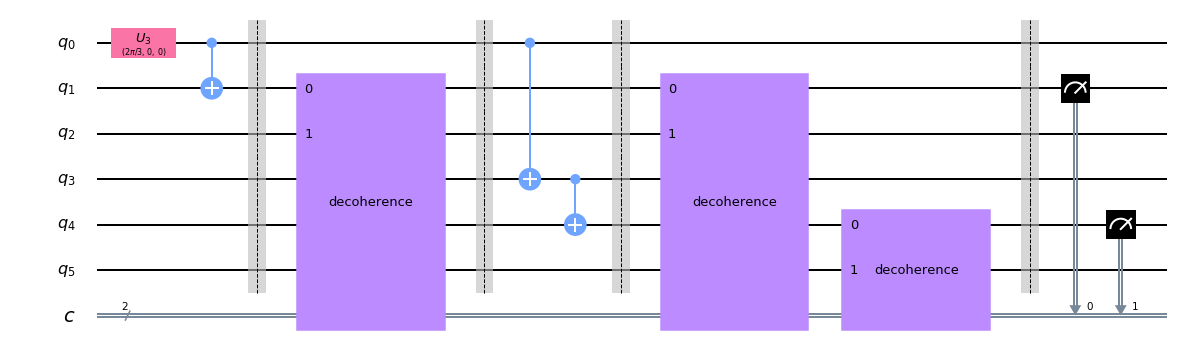

In [5]:
getCircuitG(pop=2, time=2).draw(output='mpl')

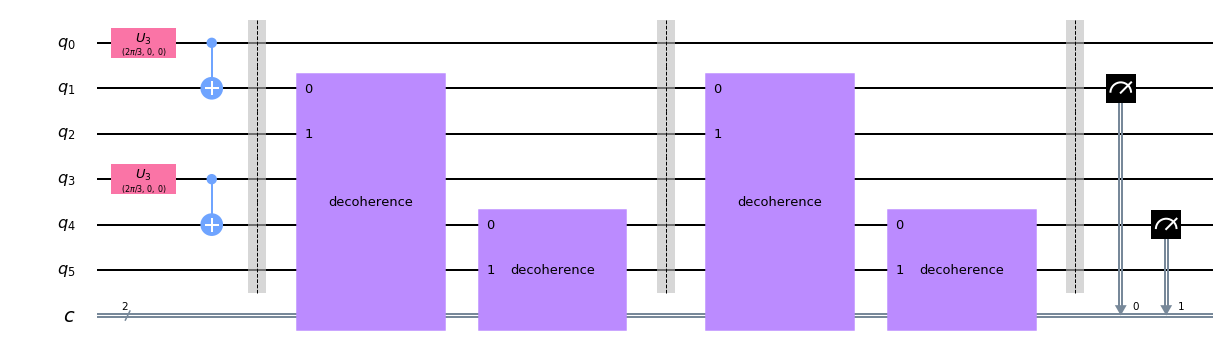

In [6]:
getCircuit(pop=2, time=2).draw(output='mpl')

## Analisis de valores optimos segun simulacion

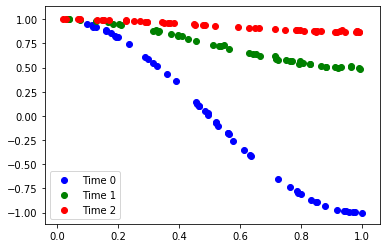

In [7]:
color = ["b","g","r"]

def checkPopulationParameters(shot = 50, timeSet = [0,1,2], parameter = "changed"):
    global fileNum
    for j in range(0,len(timeSet)):
        x =  []
        y = []

        for i in range(int(shot)):
            if(i%10==0):
                sys.stdout.write(f"Work progress: Iteration {j} - {100*float(i)/(shot)}%   \r" )
                sys.stdout.flush()
            rand = random.uniform(0, 1)
            x+= [rand]
            timeT = timeSet[j]
            if (parameter=="changed"):
                qc = getCircuit(time = timeT, changed=rand*np.pi)
                
            elif(parameter=="initial"):
                qc = getCircuit(time = timeT, initial=rand*np.pi)
            y += [getExpectedValue(qc)]
        plt.scatter(x, y,c=color[j], label=f"Time {timeSet[j]}")


    plt.legend(loc="lower left")
    plt.savefig(f"file_RA{fileNum}_N{shot}.png")
    fileNum+=1
checkPopulationParameters(parameter="initial")

Gráfica que muestra la variación del valor esperado de sigma_z (eje y) con el ángulo correspondiente al giro en u3 que nos da el estado inicial (eje x). Podemos ver cómo al aumentar el número de pasos de tiempo (0,1,2) disminuye la dependencia del valor esperado de sigma_z con el estado inicial. Para el tiempo 2 obtenemos unos valores aproximadamente constantes para el valor esperado, teniendo como resultado 1, es decir, el correspondiente al qubit 0. Por lo tanto tendremos a nuestros individuos "muertos", ya que el paso del tiempo hace que los individuos envejezcan y por lo tanto llega un momento en el que independientemente del estado inicial todos los individuos acaban muriendo (asintóticamente).

## Ejemplo de creacion de circuito y simulacion


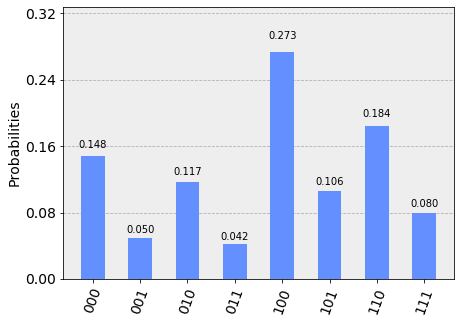

In [8]:
qc = getCircuitG(time=3,pop=3, initial=np.pi, changed = np.pi/5)
printHistogram(qc, shots=1000)

El bit menos significativo corresponde al primer individuo (el más viejo). El valor 1 corresponde a vivo y el 0 a muerto. Es de esperar que conforme pase el tiempo sea más probable encontrar que los individuos más viejos están muertos. Efectivamente el estado más probable después de crear tres individuos y sus correspondientes pasos de tiempo es que los tres individuos estén muertos, 000. A continuación encontramos el caso 100, es decir, el más joven vivo y los otros muertos. Como era de esperar el valor menos probable es aquel en el que los tres individuos están vivos tras el paso del tiempo 111.

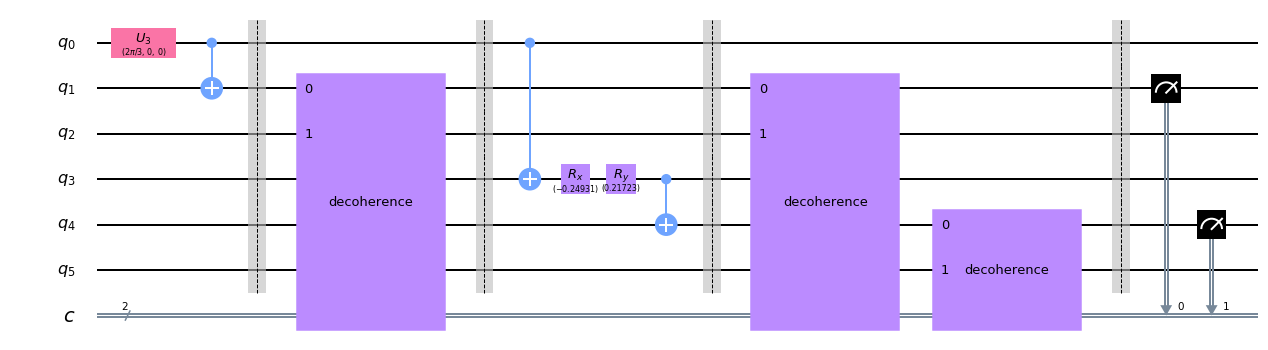

In [15]:
qc = getCircuitG(pop=2, time=2,mutation=True, mutationRate=0.5)
#addTimeLapse(qc, time=3)
qc.draw(output='mpl')

## Modelo de reproducción sexual

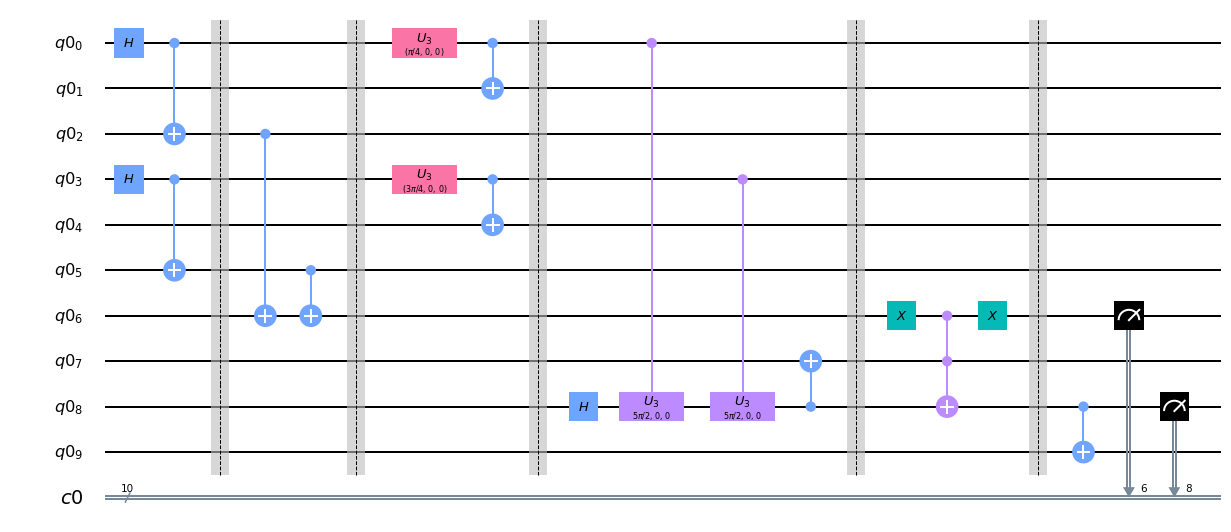

In [10]:

q=QuantumRegister(10)
c=ClassicalRegister(10)
qc=QuantumCircuit(q,c)

qc.h(q[0])
qc.cx(q[0],q[2])
qc.h(q[3])
qc.cx(q[3],q[5])
qc.barrier()
qc.cx(q[2],q[6])
qc.cx(q[5],q[6])
qc.barrier()
qc.u3(np.pi/4,0,0,q[0])
qc.cx(q[0],q[1])
qc.u3(3*np.pi/4,0,0,q[3])
qc.cx(q[3],q[4])
qc.barrier()
qc.h(q[8])
qc.cu3(5*np.pi/2,0,0,q[0],q[8])
qc.cu3(5*np.pi/2,0,0,q[3],q[8])
qc.cx(q[8],q[7])
qc.barrier()
qc.x(q[6])
qc.ccx(q[6],q[7],q[8])
qc.x(q[6])
qc.barrier()
qc.cx(q[8],q[9])


qc.measure(q[6],c[6])
qc.measure(q[8],c[8])



backend=Aer.get_backend('qasm_simulator')
result=execute(qc,backend).result().get_counts()
qc.draw(output='mpl')

In [11]:
fig = plot_histogram(result)
fig.savefig("img.png", bbox_inches = "tight")

## Entornos no constantes

Algunas veces no buscaremos utilizar entornos constantes. Analizamos como desarrollar un entorno no constante.

Lo primero que queremos es saber como podemos encontrar formas de aumentar el valor del fenotipo para posibles enviroments que sean beneficiosos para el individuo. Sabemos que el _decoherence gate_ que hemos implementado reduce el valor en $|1⟩$ de el bit 1 del gate en un grado definido por nosotros en el CRY. Para lograr que aumente el valor, solo necesitamos negarla antes de ejecutar el _decoherence_ y posteriormente volver a negarlo.

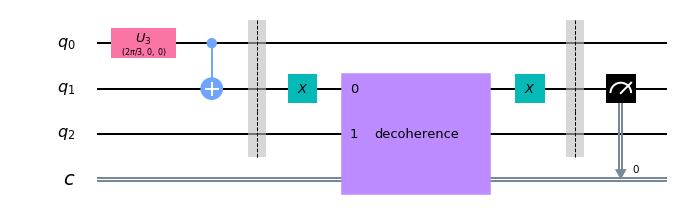

Una vez hemos tenido en cuenta la posibilidad de aumentos y reducciones en el fenotipo, podemos crear entornos personalizados para simular situaciones mas cercanas a la vida real. Para que el aumento del fenotipo tenga sentido hay que entender que este tipo de simulaciones permiten _"revivir"_. Este hecho se puede entender haciendo ver al fenotipo como un parametro de varios posibles fenotipos de un unico individuo pero que sostienen diferentes variables. Un ejemplo podria ser la temperatura de un individuo. Podemos crear un enviroment ciclico tal que en verano y primavera el fenotivo crece mientras que en invierno y otoño se reduce.

In [12]:
# Crea un circuito general de una Artificial Life de poblacion 1 con un background customizado
#
# time    : Integer representando la cantidad de iteraciones
# initial : Float que representa los radiones de la gate U3 inicial
# changed : Float que representa los radianes de la gate CRY
# pop     : Integer representando la cantidad de poblacion que tendra el algoritmo
def getCircuitCB(pop=1,time=3, initial=theta, changed=theta, measure = True,
                 background_change=[np.pi/4,np.pi/8,np.pi/4], background_sign = [0,1,0]):
    
    
    qc = QuantumCircuit(3*pop,pop)
    for i in range(pop):
        qc.u3(initial,0,0,i*3)
        qc.cx(i*3,i*3+1)
    qc.barrier()

    for i in range(0,time):
        #cry
        for j in range(pop):
            decoherenceG = getDecoherence(background_change[i]).to_instruction()
            if(background_sign[i]==1):
                qc.x(j*3+1)
            qc.append(decoherenceG, [j*3+1,j*3+2],[j])
            if(background_sign[i]==1):
                qc.x(j*3+1)
        qc.barrier()
    if(measure):
        qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    return qc

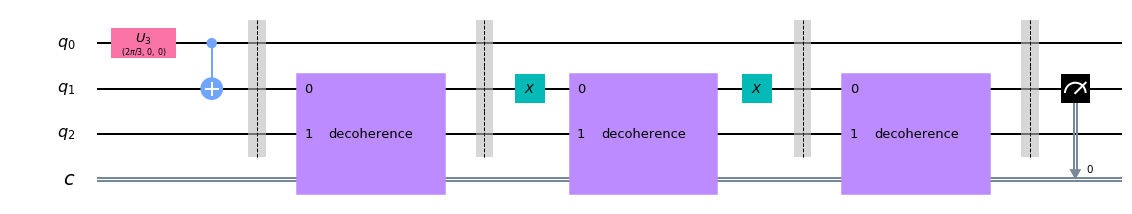

In [14]:
getCircuitCB(pop=1, time=3).draw(output='mpl')